<img src="sghlogo.png" alt="drawing" width="400"/>

# Statystyczne metody wielowymiarowej analizy porównawczej 

## Praca zaliczeniowa

Uladzislau Darhevich

Numer indeksu: ***108519***

email: ud108519@student.sgh.waw.pl

## Opis danych

Wydział Statystyki Organizacji Narodów Zjednoczonych (ang. *The United Nations Statistics Division*) w Departamencie Spraw Gospodarczych i Społecznych uruchomił nowy internetowy serwis danych dla globalnej społeczności użytkowników. Dzięki niemu statystyczne bazy danych ONZ są łatwo dostępne dla użytkowników poprzez pojedynczy punkt dostępu (http://data.un.org/). Użytkownicy mogą wyszukiwać i pobierać różne zasoby statystyczne systemu ONZ. 

Ten zbiór danych zawiera kluczowe wskaźniki statystyczne dla poszczególnych krajów. Obejmuje on 4 główne sekcje:

    - Informacje ogólne
    - Wskaźniki ekonomiczne
    - Wskaźniki społeczne
    - Wskaźniki środowiskowe i infrastrukturalne

Dane pochodzą z roku 2017, jeśli są dostępne, lub z najbardziej aktualnych danych sprzed roku. Ilość wskaźników - 62. Ilość karajów lub teritorium - 229.

## Hipoteza badawcza

Zrobic porównanie analizy taksonomicznej oraz analizy czynnikowej odnośnie zbióra danych.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns   
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis


import pycountry
import geopandas

sns.set_theme(context='notebook', style='white', palette='bright')
SEED = 1234

In [2]:
df = pd.read_csv('../data/data_multidim/country_profile_variables.csv')

In [3]:
repalce_country_names = {
            'Bolivia (Plurinational State of)' : 'Bolivia, Plurinational State of',
            'British Virgin Islands' : 'Virgin Islands, British',
            'Channel Islands' : "Jersey",
            'China, Hong Kong SAR' : "Hong Kong",
            'China, Macao SAR': 'Macao',
            "Democratic People's Republic of Korea" : "Korea, Democratic People's Republic of",
            'Democratic Republic of the Congo' : "Congo, The Democratic Republic of the",
            'Holy See' : "Holy See (Vatican City State)",
            'Iran (Islamic Republic of)' : "Iran, Islamic Republic of",
            'Micronesia (Federated States of)' : "Micronesia, Federated States of",
            'Republic of Korea' : "Korea, Republic of",
             'Republic of Moldova' : "Moldova, Republic of",
             'Saint Helena' : "Saint Helena, Ascension and Tristan da Cunha",
             'State of Palestine': "Palestine, State of",
             'Swaziland' : "Eswatini",
             'The former Yugoslav Republic of Macedonia' : "North Macedonia",
             'United Republic of Tanzania' : "Tanzania, United Republic of",
             'United States of America': "United States",
             'United States Virgin Islands': "Virgin Islands, U.S.",
             'Venezuela (Bolivarian Republic of)': "Venezuela, Bolivarian Republic of",
             'Wallis and Futuna Islands' : "Wallis and Futuna"}
df['country'].replace(repalce_country_names, inplace=True)

Przykład wiersza z danymi

In [4]:
df.iloc[66,]

country                                                              Estonia
Region                                                        NorthernEurope
Surface area (km2)                                                     45227
Population in thousands (2017)                                          1310
Population density (per km2, 2017)                                      30.9
Sex ratio (m per 100 f, 2017)                                           88.2
GDP: Gross domestic product (million current US$)                      22460
GDP growth rate (annual %, const. 2005 prices)                           1.4
GDP per capita (current US$)                                         17112.0
Economy: Agriculture (% of GVA)                                          3.4
Economy: Industry (% of GVA)                                            27.4
Economy: Services and other activity (% of GVA)                         69.2
Employment: Agriculture (% of employed)                                  3.8

In [5]:
df = df.applymap(lambda x: np.nan if x == -99 else x)

In [6]:
list_of_cols = ['Surface area (km2)', 'GDP growth rate (annual %, const. 2005 prices)', 'Economy: Agriculture (% of GVA)',
            'Employment: Agriculture (% of employed)', 'Employment: Industry (% of employed)', 'Employment: Services (% of employed)',
            'Unemployment (% of labour force)', 'International trade: Exports (million US$)', 'International trade: Imports (million US$)',
            'International trade: Balance (million US$)', 'Balance of payments, current account (million US$)',
            'Population growth rate (average annual %)', 'Urban population growth rate (average annual %)', 'Fertility rate, total (live births per woman)',
            'Refugees and others of concern to UNHCR (in thousands)', 'Infant mortality rate (per 1000 live births',
            'Health: Physicians (per 1000 pop.)', 'Education: Government expenditure (% of GDP)', 'Mobile-cellular subscriptions (per 100 inhabitants)',
            'Mobile-cellular subscriptions (per 100 inhabitants).1', 'Pop. using improved sanitation facilities (urban/rural, %)','Threatened species (number)']

In [7]:
def col_to_numeric(col):
    col = col.apply(lambda x: np.nan if x == '-99' else x)
    col = pd.to_numeric(col, errors='coerce')
    return col

In [8]:
df[list_of_cols] = df[list_of_cols].apply(col_to_numeric)

In [9]:
list_of_cols_paired = ['Labour force participation (female/male pop. %)', 'Life expectancy at birth (females/males, years)', 'Population age distribution (0-14 / 60+ years, %)',
                      'International migrant stock (000/% of total pop.)', 'Education: Primary gross enrol. ratio (f/m per 100 pop.)',
                      'Education: Secondary gross enrol. ratio (f/m per 100 pop.)', 'Education: Tertiary gross enrol. ratio (f/m per 100 pop.)',
                      'Forested area (% of land area)', 'Energy supply per capita (Gigajoules)', 'Pop. using improved drinking water (urban/rural, %)']

In [10]:
def seperate_paired_columns(col, df):
    col = col.apply(lambda x: np.nan if x == '-99' else x)
    tmp = col.str.split('/', 1, expand=True)
    tmp.columns = [col.name + "_option_A", col.name + "_option_B"]
    tmp = tmp.apply(pd.to_numeric, errors='coerce')
    df[tmp.columns.to_list()] = tmp

In [11]:
df[list_of_cols_paired] = df[list_of_cols_paired].apply(seperate_paired_columns, df=df)

In [12]:
df = df.drop(list_of_cols_paired, axis=1)
df = df.drop(['Net Official Development Assist. received (% of GNI)'], axis=1)

In [13]:
df.shape

(229, 59)

In [14]:
country = df['country']
region = df['Region']
df_num = df.iloc[:, 2:]

In [15]:
imputer = KNNImputer()
imputer.fit(df_num)
X_imputed = pd.DataFrame(imputer.transform(df_num), columns=df_num.columns)

In [16]:
scaler = StandardScaler()
scaler.fit(X_imputed)
X_transform = pd.DataFrame(scaler.transform(X_imputed), columns=X_imputed.columns)

# Analiza taksonomiczna

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [17]:
%%time
tsne = TSNE(random_state=SEED, init='pca', n_jobs=-1)
X_tsne = tsne.fit_transform(X_transform)

Wall time: 1.46 s


<Figure size 576x576 with 0 Axes>

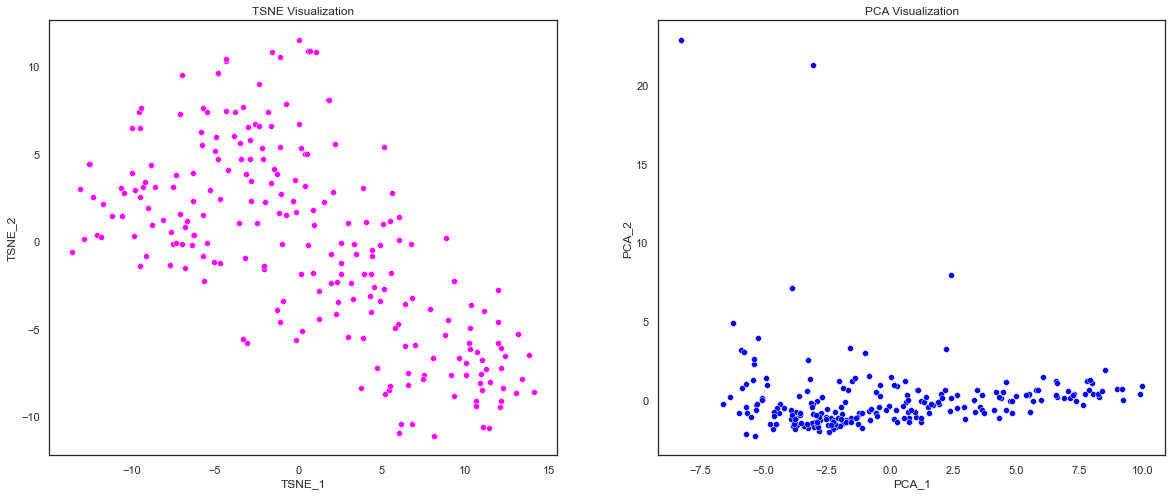

In [18]:
X_tsne = pd.DataFrame(X_tsne , columns=['TSNE_1', 'TSNE_2'])
plt.figure(figsize=(8, 8)) 
pca = PCA(n_components=2, random_state=SEED)
pca.fit(X_transform)
X_pca = pca.transform(X_transform)
X_pca = pd.DataFrame(X_pca, columns=['PCA_1', 'PCA_2'])
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8));
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', ax=axes[0], color='magenta').set_title('TSNE Visualization');
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', ax=axes[1], color='blue').set_title('PCA Visualization');

In [19]:
pca = PCA(random_state=SEED)
pca.fit_transform(X_transform)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

Wykres Współczynnik wariancji wyjaśnionej

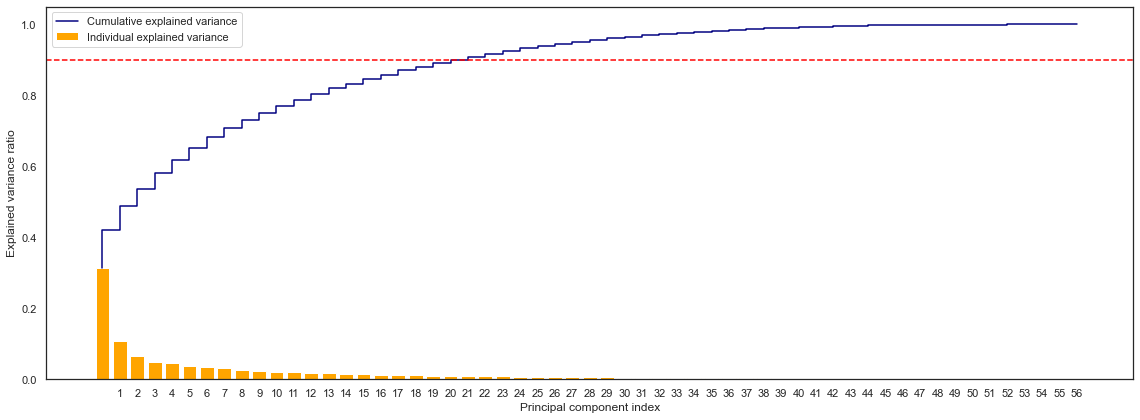

In [20]:
plt.figure(figsize=(16, 6)) 
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=1,
            align='center', color='orange',
            label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues,
            where='pre', color = 'navy',
            label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(np.arange(1, X_transform.shape[1], 1))
plt.legend(loc='best')
plt.tight_layout()
plt.axhline(y=0.9, color="red", linestyle='--')
plt.show()

In [21]:
pca = PCA(n_components = 20, random_state=SEED)
X_pca_tr = pca.fit_transform(X_transform)

# Analiza czynnikowa

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [22]:
fa = FactorAnalyzer(rotation = None, impute = "drop", n_factors=X_transform.shape[1])
fa.fit(X_transform)
ev,_ = fa.get_eigenvalues()

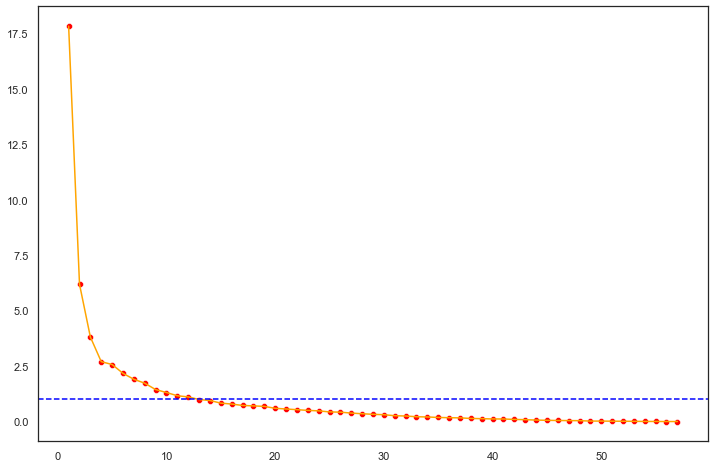

In [23]:
plt.figure(figsize=(12, 8))
sns.lineplot(x=range(1, X_transform.shape[1] + 1), y=ev, color='orange')
sns.scatterplot(x=range(1, X_transform.shape[1] + 1), y=ev, color='red')
plt.axhline(y=1, color="blue", linestyle='--');

In [24]:
fa = FactorAnalyzer(n_factors=12, rotation='varimax')
fa.fit(X_transform)
X_fa_tr = fa.transform(X_transform)
pd.DataFrame(fa.loadings_, index=X_transform.columns).head()

,0,1,2,3,4,5,6,7,8,9,10,11
Surface area (km2),-0.004256,0.655471,0.026551,-0.078975,0.090371,-0.080701,-0.019327,-0.005504,-0.006574,0.007769,0.056156,-0.157835
Population in thousands (2017),-0.039332,0.728133,-0.083643,0.252580,0.073958,-0.073168,0.012854,-0.038240,-0.014682,-0.153057,-0.086504,0.093679
"Population density (per km2, 2017)",0.126534,-0.033565,0.037264,0.026360,-0.066709,0.038427,0.021625,0.037357,0.564393,0.004654,0.032314,0.003839
"Sex ratio (m per 100 f, 2017)",0.023712,-0.012609,0.748648,0.020430,0.020513,-0.063588,0.030676,-0.065217,-0.030715,-0.166931,-0.082488,0.202910
GDP: Gross domestic product (million current US$),0.101237,0.918821,0.025854,-0.264730,-0.033560,0.088360,-0.022195,0.007023,-0.005092,0.062416,0.004560,0.007721


In [25]:
pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])

,0,1,2,3,4,5,6,7,8,9,10,11
Variance,16.386088,6.021422,3.027597,2.45326,2.177357,1.871355,1.855084,1.571374,1.559594,1.323851,1.138636,1.070007
Proportional Var,0.287475,0.105639,0.053116,0.04304,0.038199,0.032831,0.032545,0.027568,0.027361,0.023225,0.019976,0.018772
Cumulative Var,0.287475,0.393114,0.446230,0.48927,0.527469,0.560300,0.592845,0.620413,0.647774,0.671000,0.690976,0.709748


# Porównywanie wyników

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [26]:
inertia_pca = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(X_pca_tr)
    inertia_pca.append(np.sqrt(kmeans.inertia_))
    
interia_fa = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(X_fa_tr)
    interia_fa.append(np.sqrt(kmeans.inertia_))

Wybór ilości klastrów dla metody k-średnich.

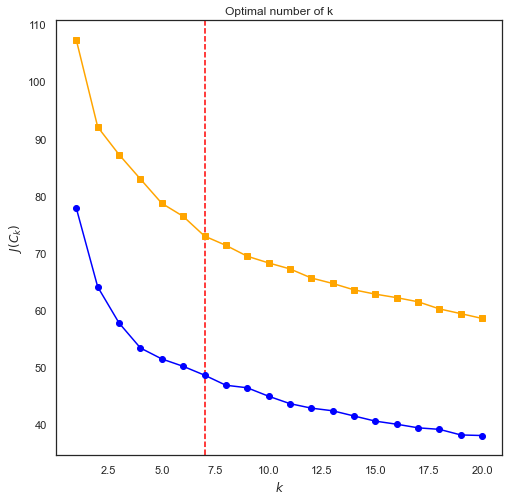

In [27]:
plt.figure(figsize=(8, 8)) 
plt.axvline(x=7, color="red", linestyle='--')
plt.plot(range(1, 21), inertia_pca, marker='s', color="orange");
plt.plot(range(1, 21), interia_fa, marker='o', color="blue");
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.title('Optimal number of k');

In [34]:
N_CLUSTERS = 8

Porównanie metody k-średnich z innymi metodami

In [35]:
#other algorithms and metrics
algorithms = []
algorithms.append(KMeans(n_clusters=N_CLUSTERS, random_state=SEED))
algorithms.append(AffinityPropagation(random_state=SEED))
algorithms.append(SpectralClustering(n_clusters=N_CLUSTERS, random_state=SEED, n_jobs=-1, affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=N_CLUSTERS))
data = []
for algo in tqdm(algorithms):
    algo.fit(X_pca_tr)
    data.append(({
        'Silhouette Score': metrics.silhouette_score(X_pca_tr, algo.labels_, random_state=SEED), 
        'Calinski-Harabasz Score': metrics.calinski_harabasz_score(X_pca_tr, algo.labels_),
        'Davies-Bouldin Score': metrics.davies_bouldin_score(X_pca_tr, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'],
                       index=['K-means', 'Affinity Propagation', 'Spectral Clustering', 'AgglomerativeClustering'])
# Silhouette Score - The best value is 1 and the worst value is -1.
# higher Calinski-Harabasz score relates to a model with better defined clusters.
# Davies-Bouldin Score: values closer to zero indicate a better partition.
results

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
K-means,0.137521,39.795623,1.545158
Affinity Propagation,0.093643,22.711460,1.403965
Spectral Clustering,0.073185,26.639114,1.932493
AgglomerativeClustering,0.140521,37.795582,1.267959


In [36]:
#other algorithms and metrics
algorithms = []
algorithms.append(KMeans(n_clusters=N_CLUSTERS, random_state=SEED))
algorithms.append(AffinityPropagation(random_state=SEED))
algorithms.append(SpectralClustering(n_clusters=N_CLUSTERS, random_state=SEED, n_jobs=-1, affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=N_CLUSTERS))
data = []
for algo in tqdm(algorithms):
    algo.fit(X_fa_tr)
    data.append(({
        'Silhouette Score': metrics.silhouette_score(X_fa_tr, algo.labels_, random_state=SEED), 
        'Calinski-Harabasz Score': metrics.calinski_harabasz_score(X_fa_tr, algo.labels_),
        'Davies-Bouldin Score': metrics.davies_bouldin_score(X_fa_tr, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'],
                       index=['K-means', 'Affinity Propagation', 'Spectral Clustering', 'AgglomerativeClustering'])
# Silhouette Score - The best value is 1 and the worst value is -1.
# higher Calinski-Harabasz score relates to a model with better defined clusters.
# Davies-Bouldin Score: values closer to zero indicate a better partition.
results

 25%|█████████████████████                                                               | 1/4 [00:00<00:01,  1.66it/s]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [37]:
final_model_k_means = KMeans(n_clusters=N_CLUSTERS, random_state=SEED)
final_model_k_means.fit(X_pca_tr)
labels = final_model_k_means.labels_

Wizualizacja

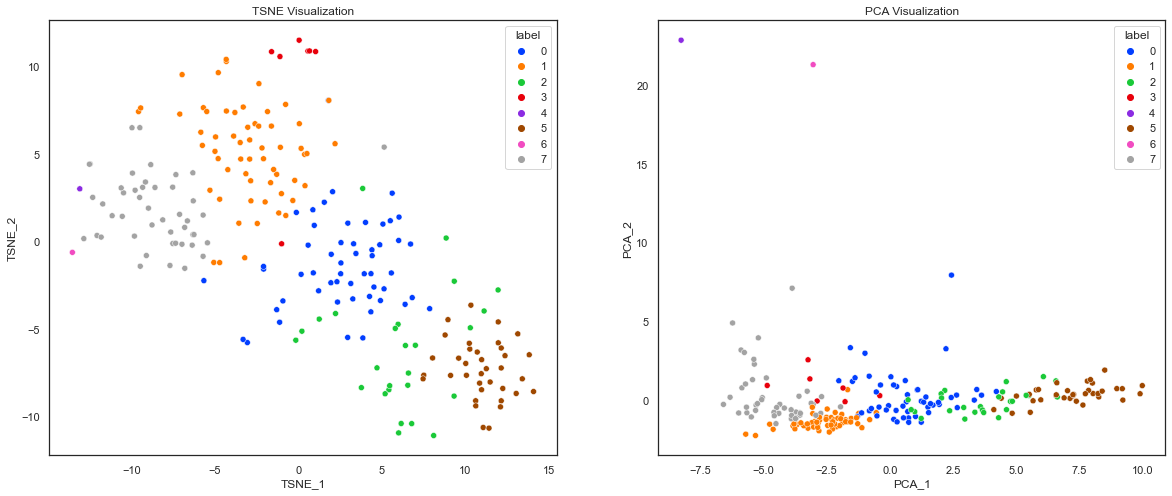

In [38]:
X_pca['label'] = labels
X_pca['country'] = country
X_pca['region'] = region
X_tsne['label'] = labels
X_tsne['country'] = country
X_tsne['region'] = region
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', hue='label',
                ax=axes[0], palette='bright').set_title('TSNE Visualization');
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', hue='label',
                ax=axes[1], palette='bright').set_title('PCA Visualization');

In [39]:
df['label'] = labels

In [40]:
def get_alpha_3(col):
    countries = {}
    for country in pycountry.countries:
        countries[country.name] = country.alpha_3
    return [countries.get(country, 'Unknown code') for country in col]

In [41]:
df['alpha_3'] = get_alpha_3(df['country'])

In [42]:
world = geopandas.read_file('../data/data_multidim/ne_10m_admin_0_countries_pol.zip')

In [43]:
df_map = df[['country', 'alpha_3', 'label']]
world_map = pd.merge(world, df_map, how='inner', left_on=['GU_A3'], right_on=['alpha_3'])

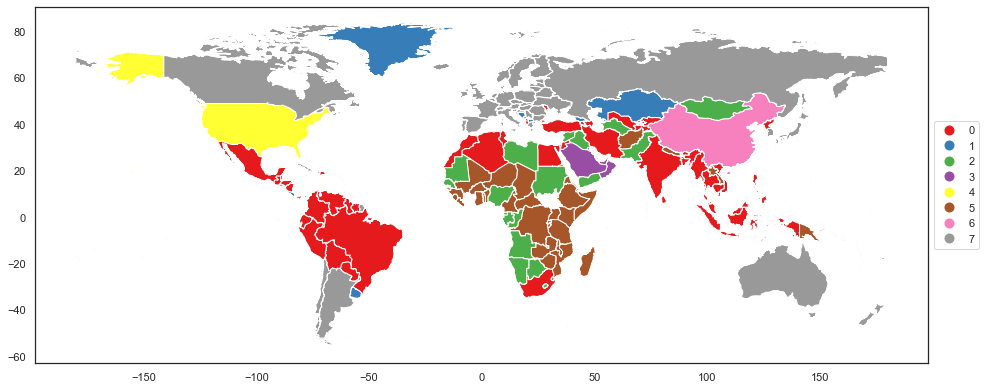

In [44]:
world_map.plot(figsize=(16, 9),
               column='label',
               cmap='Set1',
               legend=True,
               categorical=True,
               legend_kwds={'loc': 'center left',
                            'bbox_to_anchor':(1, 0.5)}
                  );

In [ ]:
# !jupyter nbconvert project_mulidim.ipynb --to html --no-input